<a href="https://colab.research.google.com/github/s34836/WUM/blob/main/Lab_10_Recurrent_Networks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10 - Recurrent Networks 2
## Text vectorization

Text data can be vectorized using `TextVectorization`.

### "Bag-of-words" models
- Binary encoding: the text is encoded as a binary vector, in which the value 1 on the i-th position means that the text contains the i-th word in the generated dictionary (`output_mode="multi_hot"`)
- Frequency encoding: the i-th position contains the frequency of the i-th word. (`output_mode="count"`)
- It is possible to encode n-grams (sequences of n words). (e.g. `ngrams=2`)
- Frequencies can be normalized using TF-IDF. (`output_mode="tf_idf"`)

## Sequential model

- Texts can be encoded as sequences of numbers `output="int"`.
- The numbers in each sequence can be vectorized using one-hot encoding or with an `Embedding` layer.

## Tasks

1. The `aclImdb` dataset contains examples of positive (`pos`) and negative (`neg`) movie reviews. Load the dataset using the `text_dataset_from_directory()` method.
2. Create a `TextVectorization` layer with `output_mode='multi_hot'`/`'count'`/`'tf_idf'` and generate the vocabulary using the `adapt()` method.
3. Create a dense network to classify the reviews. Insert the vectorization layer directly after the input layer.
4. Create a `TextVectorization` layer with `output_mode='int'` and generate the vocabulary using the `adapt()` method.
5. Create an LSTM network to classify the reviews. Insert the vectorization layer directly after the input layer, followed by an `Embedding` layer.
6. Compare several recurrent networks with different architectures. You can use GRU layers instead of LSTM layers. Rcurrent layers can be regularized by setting the `recurrent_dropout` parameter. Plot the learning curves on training/validation data.

In [1]:
!unzip -q aclImdb.zip
!ls

aclImdb  aclImdb.zip  __MACOSX	sample_data


In [2]:
#1.The aclImdb dataset contains examples of positive (pos)
#and negative (neg) movie reviews. Load the dataset using the text_dataset_from_directory() method.
import tensorflow as tf

batch_size = 32

train_data = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)

valid_data = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Dense network (example)

In [3]:
max_tokens = 5000

text_vectorization = tf.keras.layers.TextVectorization(output_mode="multi_hot", max_tokens=max_tokens)
text_vectorization.adapt(train_data.map(lambda x, y: x))

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype="string"),
    text_vectorization,
    # Add your layers here
])

### Recurrent network (example)

In [5]:
max_tokens = 5000
max_len = 600

text_vectorization = tf.keras.layers.TextVectorization(output_mode="int", max_tokens=max_tokens, output_sequence_length=max_len)
text_vectorization.adapt(train_data.map(lambda x, y: x))

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype="string"),
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=128),
    # Add your layers here
])

In [7]:
#2. Create a TextVectorization layer with output_mode='multi_hot'/'count'/'tf_idf'
# and generate the vocabulary using the adapt() method.
# 3. Create a dense network to classify the reviews. Insert the vectorization
# layer directly after the input layer.

from tensorflow.keras import layers, models

max_tokens = 5000

def make_vectorizer(output_mode):
    tv = layers.TextVectorization(
        output_mode=output_mode,
        max_tokens=max_tokens
    )
    # adaptujemy tylko na tekście (x)
    tv.adapt(train_data.map(lambda x, y: x))
    return tv

def make_dense_model(vectorizer):
    model = models.Sequential([
        layers.Input(shape=(1,), dtype="string"),
        vectorizer,
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

dense_histories = {}

for mode in ["multi_hot", "count", "tf_idf"]:
    print(f"\n=== Dense model z output_mode = '{mode}' ===")
    vec = make_vectorizer(mode)
    dense_model = make_dense_model(vec)
    history = dense_model.fit(
        train_data,
        validation_data=valid_data,
        epochs=3
    )
    dense_histories[mode] = history


=== Dense model z output_mode = 'multi_hot' ===
Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8208 - loss: 0.3863 - val_accuracy: 0.8762 - val_loss: 0.2896
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9184 - loss: 0.2036 - val_accuracy: 0.8714 - val_loss: 0.3423
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9650 - loss: 0.0957 - val_accuracy: 0.8623 - val_loss: 0.4936

=== Dense model z output_mode = 'count' ===
Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8160 - loss: 0.4096 - val_accuracy: 0.8807 - val_loss: 0.2866
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9127 - loss: 0.2175 - val_accuracy: 0.8737 - val_loss: 0.3224
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9460 - loss: 0.1350 - val_accuracy: 0.8696 - val_loss: 0.4138

=== Dense model z output_mode = 'tf_idf' ===
Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.8048 - loss: 0.4716

In [8]:
# 4. Create a TextVectorization layer with output_mode='int' and generate the vocabulary using the adapt() method.

max_tokens_seq = 10000
max_len = 200  # długość sekwencji po przycięciu/paddingu

text_vectorization_seq = layers.TextVectorization(
    output_mode="int",
    max_tokens=max_tokens_seq,
    output_sequence_length=max_len
)

text_vectorization_seq.adapt(train_data.map(lambda x, y: x))

In [9]:
#5. Create an LSTM network to classify the reviews. Insert the vectorization
# layer directly after the input layer, followed by an Embedding layer.
def make_lstm_model():
    model = models.Sequential([
        layers.Input(shape=(1,), dtype="string"),
        text_vectorization_seq,
        layers.Embedding(input_dim=max_tokens_seq, output_dim=128, mask_zero=True),
        layers.LSTM(64),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

lstm_basic_model = make_lstm_model()
lstm_basic_history = lstm_basic_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=3
)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 200ms/step - accuracy: 0.6919 - loss: 0.5639 - val_accuracy: 0.8483 - val_loss: 0.3650
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.8787 - loss: 0.2977 - val_accuracy: 0.8544 - val_loss: 0.3491
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 202s 200ms/step - accuracy: 0.9159 - loss: 0.2218 - val_accuracy: 0.8488 - val_loss: 0.4599


In [10]:
#6. Compare several recurrent networks with different architectures.
# You can use GRU layers instead of LSTM layers. Rcurrent layers can be
# regularized by setting the recurrent_dropout
# parameter. Plot the learning curves on training/validation data.
def make_rnn_model(cell_type="LSTM", bidirectional=False, units=64, recurrent_dropout=0.0):
    rnn_layer_cls = layers.LSTM if cell_type == "LSTM" else layers.GRU

    if bidirectional:
        rnn_layer = layers.Bidirectional(
            rnn_layer_cls(units, recurrent_dropout=recurrent_dropout)
        )
    else:
        rnn_layer = rnn_layer_cls(units, recurrent_dropout=recurrent_dropout)

    model = models.Sequential([
        layers.Input(shape=(1,), dtype="string"),
        text_vectorization_seq,
        layers.Embedding(input_dim=max_tokens_seq, output_dim=128, mask_zero=True),
        rnn_layer,
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

rnn_configs = {
    "LSTM_basic": dict(cell_type="LSTM", bidirectional=False, units=64, recurrent_dropout=0.0),
    "LSTM_recurrent_dropout": dict(cell_type="LSTM", bidirectional=False, units=64, recurrent_dropout=0.3),
    "BiGRU_recurrent_dropout": dict(cell_type="GRU", bidirectional=True, units=64, recurrent_dropout=0.3),
}

rnn_histories = {}

for name, cfg in rnn_configs.items():
    print(f"\n=== Trening modelu: {name} ===")
    model = make_rnn_model(**cfg)
    history = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=3
    )
    rnn_histories[name] = history


=== Trening modelu: LSTM_basic ===
Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 158s 198ms/step - accuracy: 0.7027 - loss: 0.5458 - val_accuracy: 0.8356 - val_loss: 0.3850
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 152s 194ms/step - accuracy: 0.8774 - loss: 0.3054 - val_accuracy: 0.8487 - val_loss: 0.3480
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 214s 210ms/step - accuracy: 0.9180 - loss: 0.2143 - val_accuracy: 0.8299 - val_loss: 0.6199

=== Trening modelu: LSTM_recurrent_dropout ===
Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 253s 318ms/step - accuracy: 0.6728 - loss: 0.5889 - val_accuracy: 0.7747 - val_loss: 0.4738
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 239s 306ms/step - accuracy: 0.8226 - loss: 0.4147 - val_accuracy: 0.7673 - val_loss: 0.5050
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 236s 302ms/step - accuracy: 0.8356 - loss: 0.3760 - val_accuracy: 0.8433 - val_loss: 0.3690

=== Trening modelu: BiGRU_recurrent_dropout ===
Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 468s 588ms/step - accuracy: 0.6764 - loss:

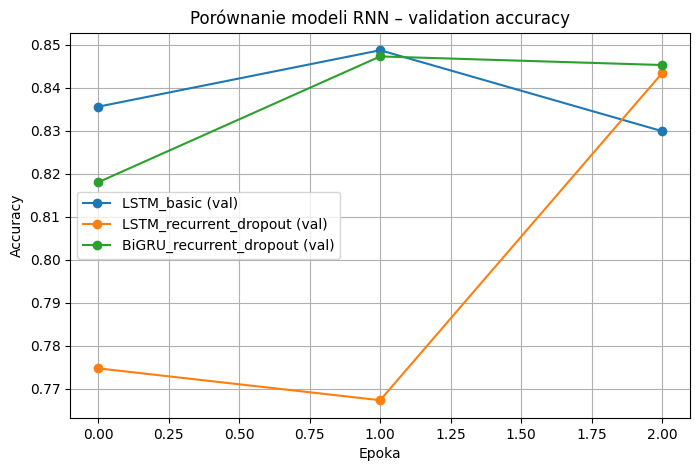

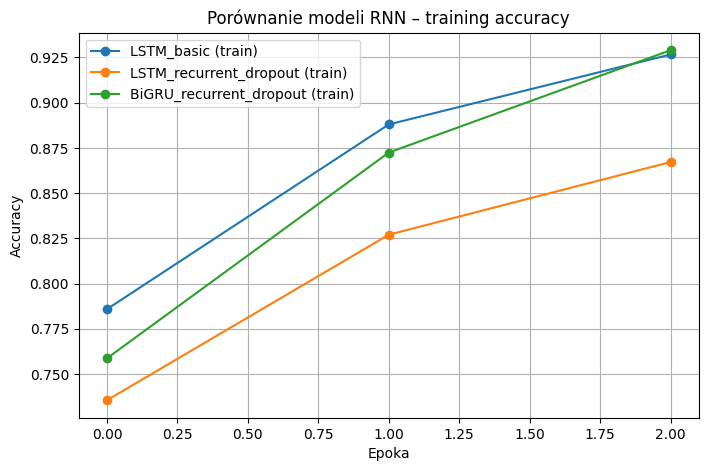

In [12]:
# wykresy
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

for name, history in rnn_histories.items():
    plt.plot(history.history["val_accuracy"], marker="o", label=f"{name} (val)")

plt.title("Porównanie modeli RNN – validation accuracy")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Opcjonalnie: training accuracy
plt.figure(figsize=(8, 5))

for name, history in rnn_histories.items():
    plt.plot(history.history["accuracy"], marker="o", label=f"{name} (train)")

plt.title("Porównanie modeli RNN – training accuracy")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()